In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
hermes_process_logs = pd.read_csv('dataset/hermes_process_logs.csv')
hermes_process_logs.head()

,id,user_id,agent_name,last_message,final_answer,escalation_status,prompt_arguments,prompt_response,state_id,state_name,...,category_name,category_description,category_summary,category_actions,tool_id,tool_name,tool_arguments,tool_response,created_at,updated_at
0,13341,6282297999004@c.us,Hermes,Noted Mbak,"Good morning, I've received the photos and the...",1.0,"{""user"": ""partner-6282297999004@c.us-20240423-...","{""data"": {""cost"": 56.625, ""completion"": {""inde...",1.0,goal-setting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-23 00:03:20,2024-04-23 00:04:56
1,13341,6282297999004@c.us,Hermes,Noted Mbak,"Good morning, I've received the photos and the...",1.0,"{""user"": ""partner-6282297999004@c.us-20240423""...","{""data"": {""cost"": 995.1, ""completion"": {""index...",3.0,generate-answer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-23 00:03:20,2024-04-23 00:04:56
2,13341,6282297999004@c.us,Hermes,Noted Mbak,"Good morning, I've received the photos and the...",1.0,"{""user"": ""partner-6282297999004@c.us-20240423""...","{""data"": {""cost"": 60.465, ""completion"": {""inde...",4.0,validate-answer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-23 00:03:20,2024-04-23 00:04:56
3,13342,HMMWZJPTAK,Hosting,"Hi, \nCan you please respond to my request abo...","Hi Sergey,\n\nThank you for reaching out with ...",2.0,"{""user"": ""guest-confirmed-HMMWZJPTAK-202404230...","{""data"": {""cost"": 39.1575, ""completion"": {""ind...",1.0,goal-setting,...,request_extension,For request messages that intent to extend the...,Sergey has requested a response regarding exte...,Handle the request to extend the booking durat...,4.0,check_property_calendar,"{""room_id"": 397675, ""check_in_date"": ""2024-04-...","{'information': ""Currently, the property that ...",2024-04-23 00:03:46,2024-04-23 00:04:24
4,13342,HMMWZJPTAK,Hosting,"Hi, \nCan you please respond to my request abo...","Hi Sergey,\n\nThank you for reaching out with ...",2.0,"{""user"": ""guest-confirmed-HMMWZJPTAK"", ""model""...","{""data"": {""cost"": 33.6825, ""completion"": {""ind...",2.0,tool-calling,...,request_extension,For request messages that intent to extend the...,Sergey has requested a response regarding exte...,Handle the request to extend the booking durat...,4.0,check_property_calendar,"{""room_id"": 397675, ""check_in_date"": ""2024-04-...","{'information': ""Currently, the property that ...",2024-04-23 00:03:46,2024-04-23 00:04:24


In [3]:
hermes_process_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103472 entries, 0 to 103471
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    103472 non-null  int64  
 1   user_id               103472 non-null  object 
 2   agent_name            103472 non-null  object 
 3   last_message          103350 non-null  object 
 4   final_answer          100469 non-null  object 
 5   escalation_status     103177 non-null  float64
 6   prompt_arguments      102772 non-null  object 
 7   prompt_response       102772 non-null  object 
 8   state_id              102772 non-null  float64
 9   state_name            102772 non-null  object 
 10  category_id           81872 non-null   float64
 11  category_name         81872 non-null   object 
 12  category_description  81872 non-null   object 
 13  category_summary      81872 non-null   object 
 14  category_actions      81863 non-null   object 
 15  

In [4]:
# check null values
hermes_process_logs.isnull().sum()

id                          0
user_id                     0
agent_name                  0
last_message              122
final_answer             3003
escalation_status         295
prompt_arguments          700
prompt_response           700
state_id                  700
state_name                700
category_id             21600
category_name           21600
category_description    21600
category_summary        21600
category_actions        21609
tool_id                 23552
tool_name               23552
tool_arguments          23552
tool_response           23746
created_at                  0
updated_at                  0
dtype: int64

In [5]:
# from onsite tool_responce column, there is two type of response
# 1. Message has been sent to staff
# 2. Message not sent because

# Function to determine if message was sent or not
def extract_response_type(response):
    if "Message has been sent to staff" in response:
        return "Sent"
    elif "Message was not sent because" in response:
        return "Not Sent"
    else:
        return "Unknown"

In [6]:
import ast

# Function to extract 'information' from the message
def extract_information(message):
    try:
        message_dict = ast.literal_eval(message)
        return message_dict.get('information', '')
    except (ValueError, SyntaxError):
        return ''

In [7]:
import ast

# Function to extract 'booking id' from the message
def extract_bookingID(data):
    try:
        bookingid_dict = ast.literal_eval(data)
        return bookingid_dict.get('booking_id', '')
    except (ValueError, SyntaxError):
        return 'not available'    

In [8]:
import re

# Define the list of common greetings
# greetings = [
#     "Hi", "Hello", "Dear", "Bonjour", "Halo", 
#     "Good morning", "Good afternoon", "Good evening"
# ]
greetings = [
    "Hi", "Hello", "Dear", "Bonjour", "Halo", 
    "Bonsoir", "Ciao", "Cher", "Liebe", "Goedenavond", 
    "Hej", "Selamat", "Merhaba", "Hai", "Guten Morgen", 
    "Good morning", "Good afternoon", "Good evening"
]

# Create the regex pattern
pattern = re.compile(r"(?:" + "|".join(greetings) + r")\s+([^\n,]+)")

# Function to extract names from messages
def extract_name(message):
    match = pattern.search(message)
    if match:
        return match.group(1).strip()
    return None

# analisis log dataset

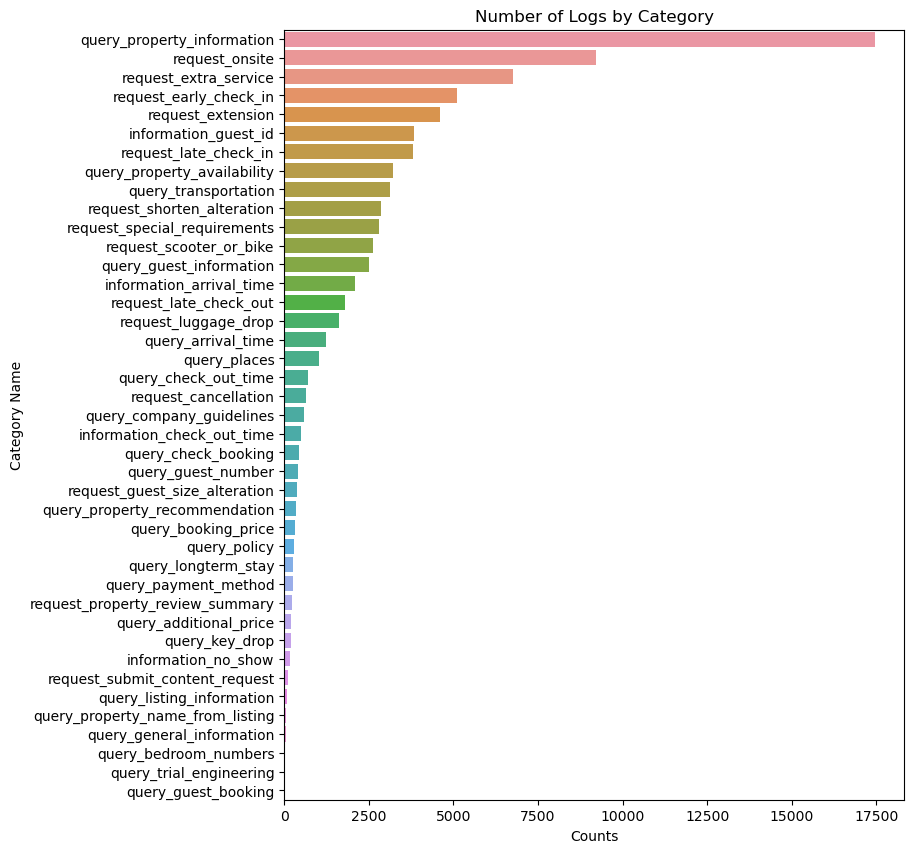

In [9]:
# groupby category name and count the number of logs horizontally
category_counts = hermes_process_logs.groupby('category_name').size().reset_index(name='counts')
category_counts = category_counts.sort_values('counts', ascending=False)

# Plot the category counts vertically
plt.figure(figsize=(8, 10))  # Adjust figure size as needed
sns.barplot(x='counts', y='category_name', data=category_counts, orient='h')  
plt.xlabel('Counts')
plt.ylabel('Category Name')
plt.title('Number of Logs by Category')
plt.show()



## check onsite request

In [10]:
# get data only for category onsite
onsite = hermes_process_logs[hermes_process_logs['category_name'] == 'request_onsite']
onsite

,id,user_id,agent_name,last_message,final_answer,escalation_status,prompt_arguments,prompt_response,state_id,state_name,...,category_name,category_description,category_summary,category_actions,tool_id,tool_name,tool_arguments,tool_response,created_at,updated_at
98,13357,HM43CK89JC,Hosting,"Hi, there’s ants in the number 3 bathroom and ...","Hi Bailey,\n\nI'm sorry to hear about the issu...",1.0,"{""user"": ""guest-confirmed-HM43CK89JC-202404230...","{""data"": {""cost"": 38.26500000000001, ""completi...",1.0,goal-setting,...,request_onsite,For guest requests related to amenities such a...,Bailey Heap reported encountering ants in the ...,Assist with on-site issues regarding ant prese...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HM43CK89JC"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-04-23 00:42:36,2024-04-23 00:43:17
99,13357,HM43CK89JC,Hosting,"Hi, there’s ants in the number 3 bathroom and ...","Hi Bailey,\n\nI'm sorry to hear about the issu...",1.0,"{""user"": ""guest-confirmed-HM43CK89JC"", ""model""...","{""data"": {""cost"": 35.3175, ""completion"": {""ind...",2.0,tool-calling,...,request_onsite,For guest requests related to amenities such a...,Bailey Heap reported encountering ants in the ...,Assist with on-site issues regarding ant prese...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HM43CK89JC"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-04-23 00:42:36,2024-04-23 00:43:17
100,13357,HM43CK89JC,Hosting,"Hi, there’s ants in the number 3 bathroom and ...","Hi Bailey,\n\nI'm sorry to hear about the issu...",1.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-1106"", ...","{""data"": {""cost"": 3.0900000000000003, ""complet...",5.0,tool-execution,...,request_onsite,For guest requests related to amenities such a...,Bailey Heap reported encountering ants in the ...,Assist with on-site issues regarding ant prese...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HM43CK89JC"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-04-23 00:42:36,2024-04-23 00:43:17
101,13357,HM43CK89JC,Hosting,"Hi, there’s ants in the number 3 bathroom and ...","Hi Bailey,\n\nI'm sorry to hear about the issu...",1.0,"{""user"": ""guest-confirmed-HM43CK89JC"", ""model""...","{""data"": {""cost"": 736.35, ""completion"": {""inde...",3.0,generate-answer,...,request_onsite,For guest requests related to amenities such a...,Bailey Heap reported encountering ants in the ...,Assist with on-site issues regarding ant prese...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HM43CK89JC"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-04-23 00:42:36,2024-04-23 00:43:17
102,13357,HM43CK89JC,Hosting,"Hi, there’s ants in the number 3 bathroom and ...","Hi Bailey,\n\nI'm sorry to hear about the issu...",1.0,"{""user"": ""guest-confirmed-HM43CK89JC"", ""model""...","{""data"": {""cost"": 46.8525, ""completion"": {""ind...",4.0,validate-answer,...,request_onsite,For guest requests related to amenities such a...,Bailey Heap reported encountering ants in the ...,Assist with on-site issues regarding ant prese...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HM43CK89JC"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-04-23 00:42:36,2024-04-23 00:43:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103441,29305,HMZFBTPSAR,Hosting,"Adel reacted to Bayu & Wayana’s message ""Hi Ad...","Hi Adel,\n\nGreat to see your positive reactio...",2.0,"{""user"": ""guest-confirmed-HMZFBTPSAR-202405230...","{""data"": {""cost"": 41.872499999999995, ""complet...",1.0,goal-setting,...,request_onsite,For guest requests related to amenities such a...,Adel acknowledged the check-in and airport pic...,Addressing additional questions or needs relat...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMZFBTPSAR"", ""guest_request_in...",{'information': 

In [11]:
onsite.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9206 entries, 98 to 103445
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9206 non-null   int64  
 1   user_id               9206 non-null   object 
 2   agent_name            9206 non-null   object 
 3   last_message          9181 non-null   object 
 4   final_answer          9105 non-null   object 
 5   escalation_status     9200 non-null   float64
 6   prompt_arguments      9206 non-null   object 
 7   prompt_response       9206 non-null   object 
 8   state_id              9206 non-null   float64
 9   state_name            9206 non-null   object 
 10  category_id           9206 non-null   float64
 11  category_name         9206 non-null   object 
 12  category_description  9206 non-null   object 
 13  category_summary      9206 non-null   object 
 14  category_actions      9206 non-null   object 
 15  tool_id               9

In [12]:
# count the number of logs for each user_id
user_counts = onsite['user_id'].value_counts().reset_index(name='counts')
user_counts = user_counts.sort_values('counts', ascending=False)

# show the top 5 users with the most logs
user_counts.head(5)

,user_id,counts
0,HM49ZD3JBF,143
1,HM8KCP8M4F,90
2,HMFQ93NB45,85
3,HM8AKS2FTC,79
4,HM2B8SWY5M,75


## check response send or not send.

In [13]:
# Ensure the 'tool_response' column is filled with empty strings where there are NaNs
onsite.loc[:,'tool_response'] = onsite['tool_response'].fillna('')

# Apply function to extract response type, and use .loc to avoid SettingWithCopyWarning
onsite = onsite.copy()
onsite.loc[:,'response_type'] = onsite['tool_response'].apply(extract_response_type)

# Count occurrences
sent_count = onsite[onsite['response_type'] == 'Sent'].shape[0]
not_sent_count = onsite[onsite['response_type'] == 'Not Sent'].shape[0]

print("Sent Count:", sent_count)
print("Not Sent Count:", not_sent_count)

Sent Count: 5748
Not Sent Count: 3091


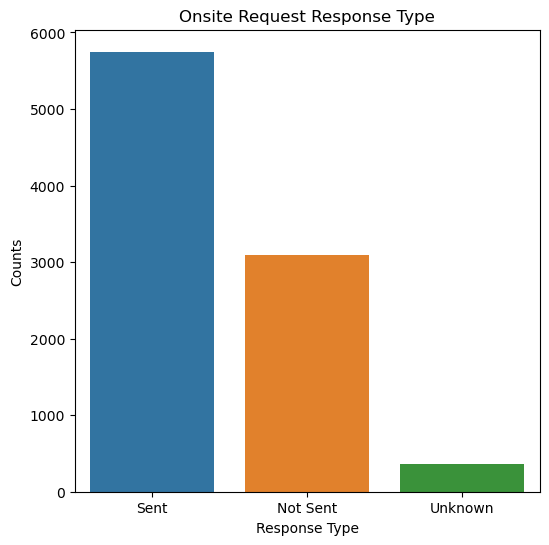

In [14]:
# Plot the response type counts
plt.figure(figsize=(6, 6))
sns.countplot(x='response_type', data=onsite)
plt.xlabel('Response Type')
plt.ylabel('Counts')
plt.title('Onsite Request Response Type')
plt.show()

In [15]:
# Recommendations
success_rate = (sent_count / (sent_count + not_sent_count)) * 100
print(f"Success Rate: {success_rate:.2f}%")
if success_rate < 90:
    print("Recommendation: Investigate the causes of unsent requests and improve system reliability.")
else:
    print("System is performing well with a high success rate.")

Success Rate: 65.03%
Recommendation: Investigate the causes of unsent requests and improve system reliability.


## make a new dataframe for the app 

In [16]:
dataset = onsite.copy()

In [17]:
dataset.isnull().sum()
dataset.dropna(inplace=True)

In [18]:
# Step 1: Filter the DataFrame
dataset = dataset[dataset['response_type'] == 'Sent']



In [19]:
# Step 2: Drop the specified columns
columns_to_drop = [
    'agent_name', 'prompt_arguments', 'prompt_response', 'category_id',
    'category_name', 'category_description', 'tool_id', 'tool_name', 
    'tool_arguments', 'tool_response'
]
dataset.drop(columns=columns_to_drop, inplace=True)

In [20]:
# Step 3: drop state_name, state_id, drop duplicate
dataset.drop(columns=['state_name', 'state_id'], inplace=True)
dataset.drop_duplicates(inplace=True)

In [21]:
# step 3 make a new column name to save name form final_answer
# Apply the function to the final_answer column and create a new column
dataset['name'] = dataset['final_answer'].apply(extract_name)

In [22]:
colum_to_drop2 = ['final_answer']# 'response_type']
dataset.drop(columns=colum_to_drop2, inplace=True)

In [23]:
# Step 4: drop if name is null
dataset.dropna(subset=['name'], inplace=True)
dataset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 736 entries, 98 to 103441
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 736 non-null    int64  
 1   user_id            736 non-null    object 
 2   last_message       736 non-null    object 
 3   escalation_status  736 non-null    float64
 4   category_summary   736 non-null    object 
 5   category_actions   736 non-null    object 
 6   created_at         736 non-null    object 
 7   updated_at         736 non-null    object 
 8   response_type      736 non-null    object 
 9   name               736 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 63.2+ KB


In [24]:
# sort dataset base on escalation_status
dataset = dataset.sort_values('escalation_status', ascending=False)

In [25]:
# save as json
dataset.to_json('dataset/onsite_requests.json', orient='records', lines=True)


## analsis dengan data baru

In [26]:
import glob

# Path to the directory containing the CSV files
file_path = 'Bangkit Data/*.csv'

# Load all CSV files
all_files = glob.glob(file_path)

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over the list of files and read each CSV file
for file in all_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Display the shape of the combined DataFrame
df.shape


(103871, 21)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103871 entries, 0 to 103870
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    103871 non-null  int64  
 1   user_id               103871 non-null  object 
 2   agent_name            103871 non-null  object 
 3   last_message          103811 non-null  object 
 4   final_answer          100879 non-null  object 
 5   escalation_status     103419 non-null  float64
 6   prompt_arguments      103205 non-null  object 
 7   prompt_response       103205 non-null  object 
 8   state_id              103205 non-null  float64
 9   state_name            103205 non-null  object 
 10  category_id           84301 non-null   float64
 11  category_name         84301 non-null   object 
 12  category_description  84301 non-null   object 
 13  category_summary      84301 non-null   object 
 14  category_actions      84301 non-null   object 
 15  

In [28]:
df.isnull().sum()

id                          0
user_id                     0
agent_name                  0
last_message               60
final_answer             2992
escalation_status         452
prompt_arguments          666
prompt_response           666
state_id                  666
state_name                666
category_id             19570
category_name           19570
category_description    19570
category_summary        19570
category_actions        19570
tool_id                 20324
tool_name               20324
tool_arguments          20324
tool_response           20450
created_at                  0
updated_at                  0
dtype: int64

In [29]:
df['category_name'].value_counts()

category_name
query_property_information          17717
request_onsite                       9260
request_extra_service                6976
request_early_check_in               5219
request_extension                    4807
information_guest_id                 4392
request_late_check_in                3736
query_transportation                 3543
query_property_availability          3121
request_special_requirements         2911
request_shorten_alteration           2706
request_scooter_or_bike              2703
information_arrival_time             2654
query_guest_information              2321
request_late_check_out               2087
request_luggage_drop                 1778
query_arrival_time                   1205
query_places                         1069
query_check_out_time                  835
request_cancellation                  552
information_check_out_time            532
query_guest_number                    478
query_company_guidelines              410
query_check_booking 

In [30]:
# Filter rows where the category_name is 'request_onsite'
onsite_requests = df[df['category_name'] == 'request_onsite']

# Display the first few rows of onsite requests
onsite_requests.head()


,id,user_id,agent_name,last_message,final_answer,escalation_status,prompt_arguments,prompt_response,state_id,state_name,...,category_name,category_description,category_summary,category_actions,tool_id,tool_name,tool_arguments,tool_response,created_at,updated_at
25,22722,HMPRWNECHN,Hosting,"Thank you, I left my used towels outside. Can ...","Hi Ianna,\n\nI've noted your request for a bed...",2.0,"{""user"": ""guest-confirmed-HMPRWNECHN-202405100...","{""data"": {""cost"": 46.365, ""completion"": {""inde...",1.0,goal-setting,...,request_onsite,For guest requests related to amenities such a...,The guest requested to have their bedsheets ch...,Coordinate with onsite staff for change of bed...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMPRWNECHN"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 00:27:10,2024-05-10 00:27:43
26,22722,HMPRWNECHN,Hosting,"Thank you, I left my used towels outside. Can ...","Hi Ianna,\n\nI've noted your request for a bed...",2.0,"{""user"": ""guest-confirmed-HMPRWNECHN"", ""model""...","{""data"": {""cost"": 43.11, ""completion"": {""index...",2.0,tool-calling,...,request_onsite,For guest requests related to amenities such a...,The guest requested to have their bedsheets ch...,Coordinate with onsite staff for change of bed...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMPRWNECHN"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 00:27:10,2024-05-10 00:27:43
27,22722,HMPRWNECHN,Hosting,"Thank you, I left my used towels outside. Can ...","Hi Ianna,\n\nI've noted your request for a bed...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.245, ""completion"": {""index...",5.0,tool-execution,...,request_onsite,For guest requests related to amenities such a...,The guest requested to have their bedsheets ch...,Coordinate with onsite staff for change of bed...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMPRWNECHN"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 00:27:10,2024-05-10 00:27:43
28,22722,HMPRWNECHN,Hosting,"Thank you, I left my used towels outside. Can ...","Hi Ianna,\n\nI've noted your request for a bed...",2.0,"{""user"": ""guest-confirmed-HMPRWNECHN"", ""model""...","{""data"": {""cost"": 881.25, ""completion"": {""inde...",3.0,generate-answer,...,request_onsite,For guest requests related to amenities such a...,The guest requested to have their bedsheets ch...,Coordinate with onsite staff for change of bed...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMPRWNECHN"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 00:27:10,2024-05-10 00:27:43
29,22722,HMPRWNECHN,Hosting,"Thank you, I left my used towels outside. Can ...","Hi Ianna,\n\nI've noted your request for a bed...",2.0,"{""user"": ""guest-confirmed-HMPRWNECHN"", ""model""...","{""data"": {""cost"": 53.385000000000005, ""complet...",4.0,validate-answer,...,request_onsite,For guest requests related to amenities such a...,The guest requested to have their bedsheets ch...,Coordinate with onsite staff for change of bed...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMPRWNECHN"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 00:27:10,2024-05-10 00:27:43


In [31]:
# get 1 example category_summary and category_action for request_onsite category 
onsite_requests.iloc[0][['last_message','category_summary', 'category_actions']].values

array(['Thank you, I left my used towels outside. Can I please have my bedsheets changed?',
       'The guest requested to have their bedsheets changed after leaving used towels outside.',
       'Coordinate with onsite staff for change of bedsheets and housekeeping service.'],
      dtype=object)

In [32]:
onsite_requests.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 9260 entries, 25 to 103870
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9260 non-null   int64  
 1   user_id               9260 non-null   object 
 2   agent_name            9260 non-null   object 
 3   last_message          9253 non-null   object 
 4   final_answer          9120 non-null   object 
 5   escalation_status     9254 non-null   float64
 6   prompt_arguments      9260 non-null   object 
 7   prompt_response       9260 non-null   object 
 8   state_id              9260 non-null   float64
 9   state_name            9260 non-null   object 
 10  category_id           9260 non-null   float64
 11  category_name         9260 non-null   object 
 12  category_description  9260 non-null   object 
 13  category_summary      9260 non-null   object 
 14  category_actions      9260 non-null   object 
 15  tool_id               9

In [33]:
print(onsite_requests['escalation_status'].value_counts())
print(onsite_requests['state_name'].value_counts())

escalation_status
2.0    7095
3.0    2159
Name: count, dtype: int64
state_name
validate-answer    2055
tool-execution     2053
generate-answer    2053
tool-calling       1703
goal-setting       1396
Name: count, dtype: int64


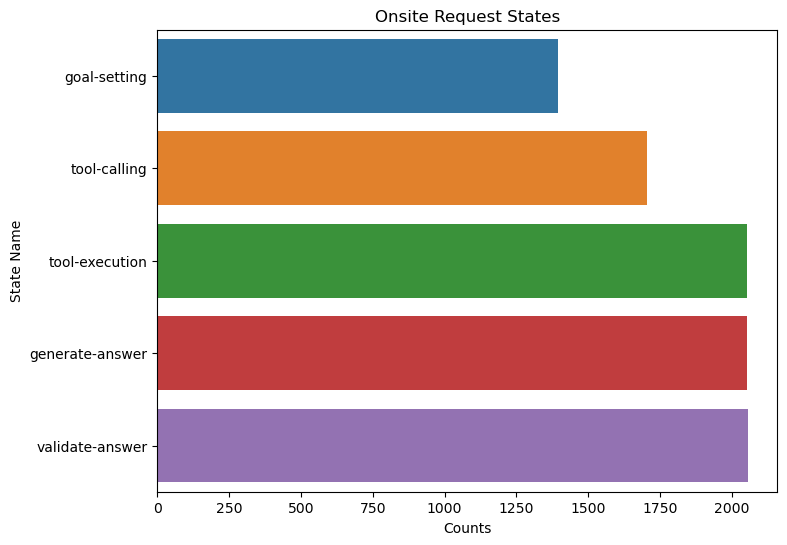

In [34]:
# plot the state_name by counts
plt.figure(figsize=(8, 6))
sns.countplot(y='state_name', data=onsite_requests)
plt.ylabel('State Name')
plt.xlabel('Counts')
plt.title('Onsite Request States')
plt.show()

In [35]:
onsite_requests.isnull().sum()
onsite_requests.dropna(inplace=True)

C:\Users\ahini\AppData\Local\Temp\ipykernel_5360\951670900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onsite_requests.dropna(inplace=True)


In [36]:
onsite_requests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9087 entries, 25 to 103870
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9087 non-null   int64  
 1   user_id               9087 non-null   object 
 2   agent_name            9087 non-null   object 
 3   last_message          9087 non-null   object 
 4   final_answer          9087 non-null   object 
 5   escalation_status     9087 non-null   float64
 6   prompt_arguments      9087 non-null   object 
 7   prompt_response       9087 non-null   object 
 8   state_id              9087 non-null   float64
 9   state_name            9087 non-null   object 
 10  category_id           9087 non-null   float64
 11  category_name         9087 non-null   object 
 12  category_description  9087 non-null   object 
 13  category_summary      9087 non-null   object 
 14  category_actions      9087 non-null   object 
 15  tool_id               9

In [37]:
# as some message is repeat 5 time for every state name. so filter only 1 state and drop duplicate
onsite_requests = onsite_requests[onsite_requests['state_name'] == 'tool-execution']
onsite_requests.drop_duplicates(inplace=True)
print(onsite_requests.shape)

(1975, 21)


In [38]:
# extract response type 
# Ensure the 'tool_response' column is filled with empty strings where there are NaNs
onsite_requests.loc[:,'tool_response'] = onsite_requests['tool_response'].fillna('')

# Apply function to extract response type, and use .loc to avoid SettingWithCopyWarning
onsite_requests = onsite_requests.copy()
onsite_requests.loc[:,'response_type'] = onsite_requests['tool_response'].apply(extract_response_type)

# count the number of sent and not sent
total_sent_requests = onsite_requests[onsite_requests['response_type'] == 'Sent'].shape[0]
total_not_sent_requests = onsite_requests[onsite_requests['response_type'] == 'Not Sent'].shape[0]
total_unkown_requests = onsite_requests[onsite_requests['response_type'] == 'Unknown'].shape[0]

print("Sent Count:", total_sent_requests)
print("Not Sent Count:", total_not_sent_requests)
print("Unknown Count:", total_unkown_requests)

Sent Count: 1281
Not Sent Count: 681
Unknown Count: 13


In [39]:
# Calculate percentages
total_requests = total_sent_requests + total_not_sent_requests
sent_percentage = (total_sent_requests / total_requests) * 100
not_sent_percentage = (total_not_sent_requests / total_requests) * 100

print("Sent Percentage:", sent_percentage)
print("Not Sent Percentage:", not_sent_percentage)


Sent Percentage: 65.29051987767585
Not Sent Percentage: 34.70948012232416


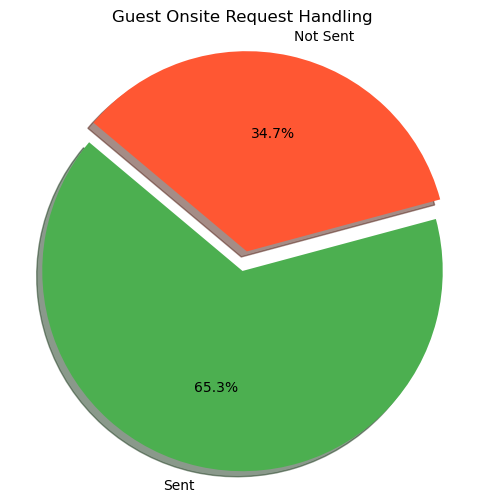

In [40]:
import matplotlib.pyplot as plt

# Pie chart for sent and not sent requests
labels = ['Sent', 'Not Sent']
sizes = [sent_percentage, not_sent_percentage]
colors = ['#4CAF50', '#FF5733']
explode = (0.1, 0)  # explode the 1st slice

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Guest Onsite Request Handling')
plt.show()


In [41]:
onsite_requests.head()

,id,user_id,agent_name,last_message,final_answer,escalation_status,prompt_arguments,prompt_response,state_id,state_name,...,category_description,category_summary,category_actions,tool_id,tool_name,tool_arguments,tool_response,created_at,updated_at,response_type
27,22722,HMPRWNECHN,Hosting,"Thank you, I left my used towels outside. Can ...","Hi Ianna,\n\nI've noted your request for a bed...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.245, ""completion"": {""index...",5.0,tool-execution,...,For guest requests related to amenities such a...,The guest requested to have their bedsheets ch...,Coordinate with onsite staff for change of bed...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMPRWNECHN"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 00:27:10,2024-05-10 00:27:43,Sent
205,22742,HMKBE38MJE,Hosting,I clicked.on the link now not working,"Hi Khaled,\n\nI apologize for the troubles the...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.5824999999999998, ""complet...",5.0,tool-execution,...,For guest requests related to amenities such a...,The user is asking about the category.,Ask for more details or context about the imag...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMKBE38MJE"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 01:26:57,2024-05-10 01:27:34,Sent
401,22768,HMXJSDJ3F4,Hosting,"Hi!\nI forgot I phone charger, do you have one?","Hi Léonard,\n\nWe understand how essential you...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.4925000000000002, ""complet...",5.0,tool-execution,...,For guest requests related to amenities such a...,The guest is inquiring about needing an iPhone...,Offer assistance for the guest's forgotten iPh...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMXJSDJ3F4"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-05-10 02:20:52,2024-05-10 02:21:13,Sent
425,22773,HMEX9CCPRT,Hosting,Do you have option to provide scooter and/or b...,"Hi Alain,\n\nThank you for reaching out. I've ...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.74, ""completion"": {""index""...",5.0,tool-execution,...,For guest requests related to amenities such a...,Alain reported that lights in two rooms are no...,Assist with the lights issue in two rooms and ...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMEX9CCPRT"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-05-10 02:24:56,2024-05-10 02:25:50,Sent
426,22773,HMEX9CCPRT,Hosting,Do you have option to provide scooter and/or b...,"Hi Alain,\n\nThank you for reaching out. I've ...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.74, ""completion"": {""index""...",5.0,tool-execution,...,For guest requests related to amenities such a...,Alain reported that lights in two rooms are no...,Assist with the lights issue in two rooms and ...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMEX9CCPRT"", ""guest_request_in...",{'information': 'Message was not sent because ...,2024-05-10 02:24:56,2024-05-10 02:25:50,Not Sent


In [42]:
# get information from tool_response
onsite_requests.loc[:,'information'] = onsite_requests['tool_response'].apply(extract_information)

# get name form final_answer
onsite_requests.loc[:,'name'] = onsite_requests['final_answer'].apply(extract_name)

onsite_requests.head()

,id,user_id,agent_name,last_message,final_answer,escalation_status,prompt_arguments,prompt_response,state_id,state_name,...,category_actions,tool_id,tool_name,tool_arguments,tool_response,created_at,updated_at,response_type,information,name
27,22722,HMPRWNECHN,Hosting,"Thank you, I left my used towels outside. Can ...","Hi Ianna,\n\nI've noted your request for a bed...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.245, ""completion"": {""index...",5.0,tool-execution,...,Coordinate with onsite staff for change of bed...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMPRWNECHN"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 00:27:10,2024-05-10 00:27:43,Sent,Message has been sent to staff. Message detail...,Ianna
205,22742,HMKBE38MJE,Hosting,I clicked.on the link now not working,"Hi Khaled,\n\nI apologize for the troubles the...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.5824999999999998, ""complet...",5.0,tool-execution,...,Ask for more details or context about the imag...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMKBE38MJE"", ""guest_request_in...","{'information': ""Message has been sent to staf...",2024-05-10 01:26:57,2024-05-10 01:27:34,Sent,Message has been sent to staff. Message detail...,Khaled
401,22768,HMXJSDJ3F4,Hosting,"Hi!\nI forgot I phone charger, do you have one?","Hi Léonard,\n\nWe understand how essential you...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.4925000000000002, ""complet...",5.0,tool-execution,...,Offer assistance for the guest's forgotten iPh...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMXJSDJ3F4"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-05-10 02:20:52,2024-05-10 02:21:13,Sent,Message has been sent to staff. Message detail...,Léonard
425,22773,HMEX9CCPRT,Hosting,Do you have option to provide scooter and/or b...,"Hi Alain,\n\nThank you for reaching out. I've ...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.74, ""completion"": {""index""...",5.0,tool-execution,...,Assist with the lights issue in two rooms and ...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMEX9CCPRT"", ""guest_request_in...",{'information': 'Message has been sent to staf...,2024-05-10 02:24:56,2024-05-10 02:25:50,Sent,Message has been sent to staff. Message detail...,Alain
426,22773,HMEX9CCPRT,Hosting,Do you have option to provide scooter and/or b...,"Hi Alain,\n\nThank you for reaching out. I've ...",2.0,"{""user"": null, ""model"": ""gpt-3.5-turbo-0125"", ...","{""data"": {""cost"": 1.74, ""completion"": {""index""...",5.0,tool-execution,...,Assist with the lights issue in two rooms and ...,21.0,send_onsite_request_to_staff,"{""booking_id"": ""HMEX9CCPRT"", ""guest_request_in...",{'information': 'Message was not sent because ...,2024-05-10 02:24:56,2024-05-10 02:25:50,Not Sent,Message was not sent because it has been sent ...,Alain


In [43]:
# Convert 'created_at' to datetime
onsite_requests['created_at'] = pd.to_datetime(onsite_requests['created_at'])
onsite_requests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1975 entries, 27 to 103851
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1975 non-null   int64         
 1   user_id               1975 non-null   object        
 2   agent_name            1975 non-null   object        
 3   last_message          1975 non-null   object        
 4   final_answer          1975 non-null   object        
 5   escalation_status     1975 non-null   float64       
 6   prompt_arguments      1975 non-null   object        
 7   prompt_response       1975 non-null   object        
 8   state_id              1975 non-null   float64       
 9   state_name            1975 non-null   object        
 10  category_id           1975 non-null   float64       
 11  category_name         1975 non-null   object        
 12  category_description  1975 non-null   object        
 13  category_summary    

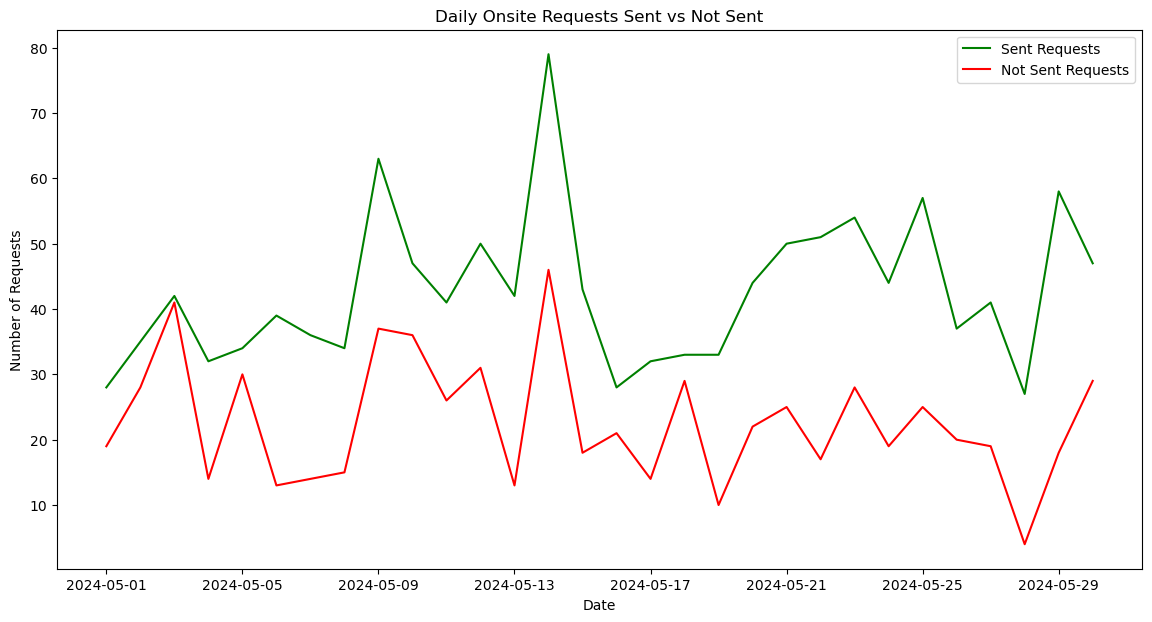

In [44]:
# # Convert 'created_at' to datetime

# Set the created_at as the index
onsite_requests.set_index('created_at', inplace=True)

# Resample by day and count sent and not sent requests
daily_sent = onsite_requests[onsite_requests['response_type'] == 'Sent'].resample('D').size()
daily_not_sent = onsite_requests[onsite_requests['response_type'] == 'Not Sent'].resample('D').size()

# Plot the frequency over time
plt.figure(figsize=(14, 7))
plt.plot(daily_sent, label='Sent Requests', color='green')
plt.plot(daily_not_sent, label='Not Sent Requests', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.title('Daily Onsite Requests Sent vs Not Sent')
plt.legend()
plt.show()


In [45]:
# make new table count of sent and not sent for each created_at
daily_counts = onsite_requests.groupby([onsite_requests.index.date, 'response_type']).size().unstack()
daily_counts.fillna(0, inplace=True)

# sort daily counts by maximum in sent
daily_counts = daily_counts.sort_values('Sent', ascending=False)
daily_counts

response_type,Not Sent,Sent,Unknown
2024-05-14,46.0,79.0,0.0
2024-05-09,37.0,63.0,0.0
2024-05-29,18.0,58.0,1.0
2024-05-25,25.0,57.0,2.0
2024-05-23,28.0,54.0,0.0
2024-05-22,17.0,51.0,0.0
2024-05-21,25.0,50.0,0.0
2024-05-12,31.0,50.0,0.0
2024-05-10,36.0,47.0,0.0
2024-05-30,29.0,47.0,0.0


In [46]:
drop_col = ['tool_id', 'tool_name', 'tool_arguments', 'prompt_arguments', 'prompt_response', 'category_id', 'category_description', 'state_name', 'state_id']
onsite_requests.drop(columns=drop_col, inplace=True)
onsite_requests.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1975 entries, 2024-05-10 00:27:10 to 2024-05-09 23:07:31
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1975 non-null   int64  
 1   user_id            1975 non-null   object 
 2   agent_name         1975 non-null   object 
 3   last_message       1975 non-null   object 
 4   final_answer       1975 non-null   object 
 5   escalation_status  1975 non-null   float64
 6   category_name      1975 non-null   object 
 7   category_summary   1975 non-null   object 
 8   category_actions   1975 non-null   object 
 9   tool_response      1975 non-null   object 
 10  updated_at         1975 non-null   object 
 11  response_type      1975 non-null   object 
 12  information        1975 non-null   object 
 13  name               1843 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 231.4+ KB


In [47]:
# check unique value for information whereresponse type not sent
tes =onsite_requests[onsite_requests['response_type'] == 'Not Sent']['information'].unique()
tes

array(['Message was not sent because it has been sent to on-site staff before.'],
      dtype=object)

In [48]:
# count number of request for each user_id 
user_counts = onsite_requests['user_id'].value_counts().reset_index(name='counts')
user_counts = user_counts.sort_values('counts', ascending=False)
user_counts

,user_id,counts
0,HM49ZD3JBF,20
1,HM8KCP8M4F,20
2,HM935ZPA9J,18
3,HM5YFWWHSN,17
4,HMZPZHH5JS,15
...,...,...
418,HM3TS2NYEM,1
419,HM3XF4AZ3W,1
420,HMCRM8Y458,1
421,HM99Y234S5,1


In [49]:
# count of request per user name
user_counts = onsite_requests['name'].value_counts().reset_index(name='counts')
user_counts = user_counts.sort_values('counts', ascending=False)
user_counts

,name,counts
0,Sophie,26
1,Jian HongWei,18
2,Jeremiah,17
4,Libby,16
5,Leona,16
...,...,...
371,Manolo,1
372,Elea,1
373,Paris!,1
374,Swee P,1


# uji 4 

In [50]:
new_df = onsite_requests.copy()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1975 entries, 2024-05-10 00:27:10 to 2024-05-09 23:07:31
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1975 non-null   int64  
 1   user_id            1975 non-null   object 
 2   agent_name         1975 non-null   object 
 3   last_message       1975 non-null   object 
 4   final_answer       1975 non-null   object 
 5   escalation_status  1975 non-null   float64
 6   category_name      1975 non-null   object 
 7   category_summary   1975 non-null   object 
 8   category_actions   1975 non-null   object 
 9   tool_response      1975 non-null   object 
 10  updated_at         1975 non-null   object 
 11  response_type      1975 non-null   object 
 12  information        1975 non-null   object 
 13  name               1843 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 231.4+ KB


In [51]:
new_df.dropna(inplace=True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1843 entries, 2024-05-10 00:27:10 to 2024-05-09 23:07:31
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1843 non-null   int64  
 1   user_id            1843 non-null   object 
 2   agent_name         1843 non-null   object 
 3   last_message       1843 non-null   object 
 4   final_answer       1843 non-null   object 
 5   escalation_status  1843 non-null   float64
 6   category_name      1843 non-null   object 
 7   category_summary   1843 non-null   object 
 8   category_actions   1843 non-null   object 
 9   tool_response      1843 non-null   object 
 10  updated_at         1843 non-null   object 
 11  response_type      1843 non-null   object 
 12  information        1843 non-null   object 
 13  name               1843 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 216.0+ KB


In [52]:
new_df['response_type'].value_counts()

response_type
Sent        1205
Not Sent     626
Unknown       12
Name: count, dtype: int64

In [53]:
# new df drop unknown
new_df = new_df[new_df['response_type'] != 'Unknown']
new_df['response_type'].value_counts()

response_type
Sent        1205
Not Sent     626
Name: count, dtype: int64

In [54]:
new_df.duplicated().sum()

651

In [55]:
new_df.drop_duplicates(inplace=True)

In [56]:
new_df['response_type'].value_counts()

response_type
Sent        855
Not Sent    325
Name: count, dtype: int64

In [57]:
# get unique information where response type is not sent
new_df[new_df['response_type'] == 'Not Sent']['information'].unique()

array(['Message was not sent because it has been sent to on-site staff before.'],
      dtype=object)

In [58]:
# save new_df as json
new_df.to_json('dataset/onsite_requests.json', orient='records', lines=True)

# buat dataset bersih untuk bangun model

In [59]:
clean_df = df.copy()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103871 entries, 0 to 103870
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    103871 non-null  int64  
 1   user_id               103871 non-null  object 
 2   agent_name            103871 non-null  object 
 3   last_message          103811 non-null  object 
 4   final_answer          100879 non-null  object 
 5   escalation_status     103419 non-null  float64
 6   prompt_arguments      103205 non-null  object 
 7   prompt_response       103205 non-null  object 
 8   state_id              103205 non-null  float64
 9   state_name            103205 non-null  object 
 10  category_id           84301 non-null   float64
 11  category_name         84301 non-null   object 
 12  category_description  84301 non-null   object 
 13  category_summary      84301 non-null   object 
 14  category_actions      84301 non-null   object 
 15  

In [60]:
clean_df['category_name'].value_counts()

category_name
query_property_information          17717
request_onsite                       9260
request_extra_service                6976
request_early_check_in               5219
request_extension                    4807
information_guest_id                 4392
request_late_check_in                3736
query_transportation                 3543
query_property_availability          3121
request_special_requirements         2911
request_shorten_alteration           2706
request_scooter_or_bike              2703
information_arrival_time             2654
query_guest_information              2321
request_late_check_out               2087
request_luggage_drop                 1778
query_arrival_time                   1205
query_places                         1069
query_check_out_time                  835
request_cancellation                  552
information_check_out_time            532
query_guest_number                    478
query_company_guidelines              410
query_check_booking 

In [61]:
clean_df['category_name'].value_counts()

category_name
query_property_information          17717
request_onsite                       9260
request_extra_service                6976
request_early_check_in               5219
request_extension                    4807
information_guest_id                 4392
request_late_check_in                3736
query_transportation                 3543
query_property_availability          3121
request_special_requirements         2911
request_shorten_alteration           2706
request_scooter_or_bike              2703
information_arrival_time             2654
query_guest_information              2321
request_late_check_out               2087
request_luggage_drop                 1778
query_arrival_time                   1205
query_places                         1069
query_check_out_time                  835
request_cancellation                  552
information_check_out_time            532
query_guest_number                    478
query_company_guidelines              410
query_check_booking 

In [62]:
# check null
clean_df.isnull().sum()

id                          0
user_id                     0
agent_name                  0
last_message               60
final_answer             2992
escalation_status         452
prompt_arguments          666
prompt_response           666
state_id                  666
state_name                666
category_id             19570
category_name           19570
category_description    19570
category_summary        19570
category_actions        19570
tool_id                 20324
tool_name               20324
tool_arguments          20324
tool_response           20450
created_at                  0
updated_at                  0
dtype: int64

In [63]:
clean_df.dropna(inplace=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82646 entries, 3 to 103870
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    82646 non-null  int64  
 1   user_id               82646 non-null  object 
 2   agent_name            82646 non-null  object 
 3   last_message          82646 non-null  object 
 4   final_answer          82646 non-null  object 
 5   escalation_status     82646 non-null  float64
 6   prompt_arguments      82646 non-null  object 
 7   prompt_response       82646 non-null  object 
 8   state_id              82646 non-null  float64
 9   state_name            82646 non-null  object 
 10  category_id           82646 non-null  float64
 11  category_name         82646 non-null  object 
 12  category_description  82646 non-null  object 
 13  category_summary      82646 non-null  object 
 14  category_actions      82646 non-null  object 
 15  tool_id               8

In [64]:
# extract information
clean_df.loc[:,'information'] = clean_df['tool_response'].apply(extract_information)

# extract name
clean_df.loc[:,'name'] = clean_df['final_answer'].apply(extract_name)

# extract booking id
clean_df.loc[:,'booking_id'] = clean_df['tool_arguments'].apply(extract_bookingID)

clean_df.head()

,id,user_id,agent_name,last_message,final_answer,escalation_status,prompt_arguments,prompt_response,state_id,state_name,...,category_actions,tool_id,tool_name,tool_arguments,tool_response,created_at,updated_at,information,name,booking_id
3,22719,1807875569,Reservation,Bonjour monsieur\nJe voudrais savoir si il y a...,"Bonjour Fran\u00e7ois,\n\nThank you for gettin...",1.0,"{""user"": ""guest-unconfirmed-1807875569-2024051...","{""data"": {""cost"": 28.275, ""completion"": {""inde...",1.0,goal-setting,...,Confirming the presence of a television in the...,1.0,get_property_information,"{""query"": ""television"", ""room_id"": ""492768"", ""...","{'information': ""## House Rules\nHouse Rules:\...",2024-05-10 00:08:20,2024-05-10 00:08:53,## House Rules\nHouse Rules:\n\n\n## Photos Ca...,Fran\u00e7ois,
4,22719,1807875569,Reservation,Bonjour monsieur\nJe voudrais savoir si il y a...,"Bonjour Fran\u00e7ois,\n\nThank you for gettin...",1.0,"{""user"": ""guest-unconfirmed-1807875569-2024051...","{""data"": {""cost"": 28.275, ""completion"": {""inde...",1.0,goal-setting,...,Confirming the presence of a television in the...,6.0,get_property_capacity_information,"{""property_name"": ""Villa Kaba""}",{'information': 'You will have an entire prope...,2024-05-10 00:08:20,2024-05-10 00:08:53,You will have an entire property with 2 bedroo...,Fran\u00e7ois,
5,22719,1807875569,Reservation,Bonjour monsieur\nJe voudrais savoir si il y a...,"Bonjour Fran\u00e7ois,\n\nThank you for gettin...",1.0,"{""user"": ""guest-unconfirmed-1807875569"", ""mode...","{""data"": {""cost"": 26.9475, ""completion"": {""ind...",2.0,tool-calling,...,Confirming the presence of a television in the...,1.0,get_property_information,"{""query"": ""television"", ""room_id"": ""492768"", ""...","{'information': ""## House Rules\nHouse Rules:\...",2024-05-10 00:08:20,2024-05-10 00:08:53,## House Rules\nHouse Rules:\n\n\n## Photos Ca...,Fran\u00e7ois,
6,22719,1807875569,Reservation,Bonjour monsieur\nJe voudrais savoir si il y a...,"Bonjour Fran\u00e7ois,\n\nThank you for gettin...",1.0,"{""user"": ""guest-unconfirmed-1807875569"", ""mode...","{""data"": {""cost"": 26.9475, ""completion"": {""ind...",2.0,tool-calling,...,Confirming the presence of a television in the...,6.0,get_property_capacity_information,"{""property_name"": ""Villa Kaba""}",{'information': 'You will have an entire prope...,2024-05-10 00:08:20,2024-05-10 00:08:53,You will have an entire property with 2 bedroo...,Fran\u00e7ois,
7,22719,1807875569,Reservation,Bonjour monsieur\nJe voudrais savoir si il y a...,"Bonjour Fran\u00e7ois,\n\nThank you for gettin...",1.0,"{""user"": ""guest-unconfirmed-1807875569"", ""mode...","{""data"": {""cost"": 619.3499999999999, ""completi...",3.0,generate-answer,...,Confirming the presence of a television in the...,1.0,get_property_information,"{""query"": ""television"", ""room_id"": ""492768"", ""...","{'information': ""## House Rules\nHouse Rules:\...",2024-05-10 00:08:20,2024-05-10 00:08:53,## House Rules\nHouse Rules:\n\n\n## Photos Ca...,Fran\u00e7ois,


In [65]:
# agent name unique values and count
clean_df['agent_name'].value_counts()

agent_name
Hosting         58761
Reservation     15267
Hermes           3522
BVGO             2790
Ask Anything     2306
Name: count, dtype: int64

In [66]:
# only keep where agent name is Hosting
clean_df = clean_df[clean_df['agent_name'] == 'Hosting']
clean_df['category_name'].value_counts()  

category_name
request_onsite                   9087
request_extra_service            6750
query_property_information       5245
request_early_check_in           5083
request_extension                4659
information_guest_id             4317
request_late_check_in            3682
request_special_requirements     2837
request_scooter_or_bike          2658
information_arrival_time         2639
request_shorten_alteration       2629
request_late_check_out           2056
query_transportation             2041
request_luggage_drop             1596
query_check_out_time              641
request_cancellation              535
information_check_out_time        504
request_guest_size_alteration     382
query_property_recommendation     352
query_places                      323
query_key_drop                    201
query_check_booking               199
information_no_show               193
query_payment_method               81
query_guest_number                 47
query_policy                       2

In [67]:
drop_col = ['tool_arguments','prompt_arguments', 'prompt_response', 'category_id', 
            'category_description', 'tool_id', 'tool_name', 'state_id',
            'agent_name']

clean_df.drop(columns=drop_col, inplace=True)

In [68]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58761 entries, 25 to 103870
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 58761 non-null  int64  
 1   user_id            58761 non-null  object 
 2   last_message       58761 non-null  object 
 3   final_answer       58761 non-null  object 
 4   escalation_status  58761 non-null  float64
 5   state_name         58761 non-null  object 
 6   category_name      58761 non-null  object 
 7   category_summary   58761 non-null  object 
 8   category_actions   58761 non-null  object 
 9   tool_response      58761 non-null  object 
 10  created_at         58761 non-null  object 
 11  updated_at         58761 non-null  object 
 12  information        58761 non-null  object 
 13  name               54873 non-null  object 
 14  booking_id         58761 non-null  object 
dtypes: float64(1), int64(1), object(13)
memory usage: 7.2+ MB


In [69]:
# make new df where only keep last message, category_name
model_df = clean_df[['last_message', 'category_name']].copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58761 entries, 25 to 103870
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   last_message   58761 non-null  object
 1   category_name  58761 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [70]:
# reclasify where reqeust onsite became onsite and other class became not onsite
model_df['category_name'] = model_df['category_name'].apply(lambda x: 'Onsite' if x == 'request_onsite' else 'Not Onsite')
model_df['category_name'].value_counts() 

category_name
Not Onsite    49674
Onsite         9087
Name: count, dtype: int64

In [71]:
model_df.to_csv('dataset/model_df2.csv', index=False)